# Feature Extraction: Version 2

In [1]:
import itertools
import cv2
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, color, feature, exposure, filters

In [2]:
TRAIN_DIR = "../data/train"
CLASSES = ["Class A", "Class B", "Class C", "Class D"]

## Mean value of Pixels

In [3]:
def calculate_mean_pixel(image_folder):
    images = os.listdir(image_folder)
    mean_pixels = []
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img_array = np.array(img)
        mean_pixel = np.mean(img_array, axis=2)
        mean_pixels.extend(mean_pixel.flatten())
    return np.array(mean_pixels)

In [4]:
def plot_histogram(ax, class_name, mean_pixels):
    ax.hist(mean_pixels, bins=50, alpha=0.7, label=class_name)
    ax.set_xlabel("Mean Pixel Values")
    ax.set_ylabel("Frequency")
    ax.set_title("Histogram of Mean Pixel Values for " + class_name)
    ax.legend()

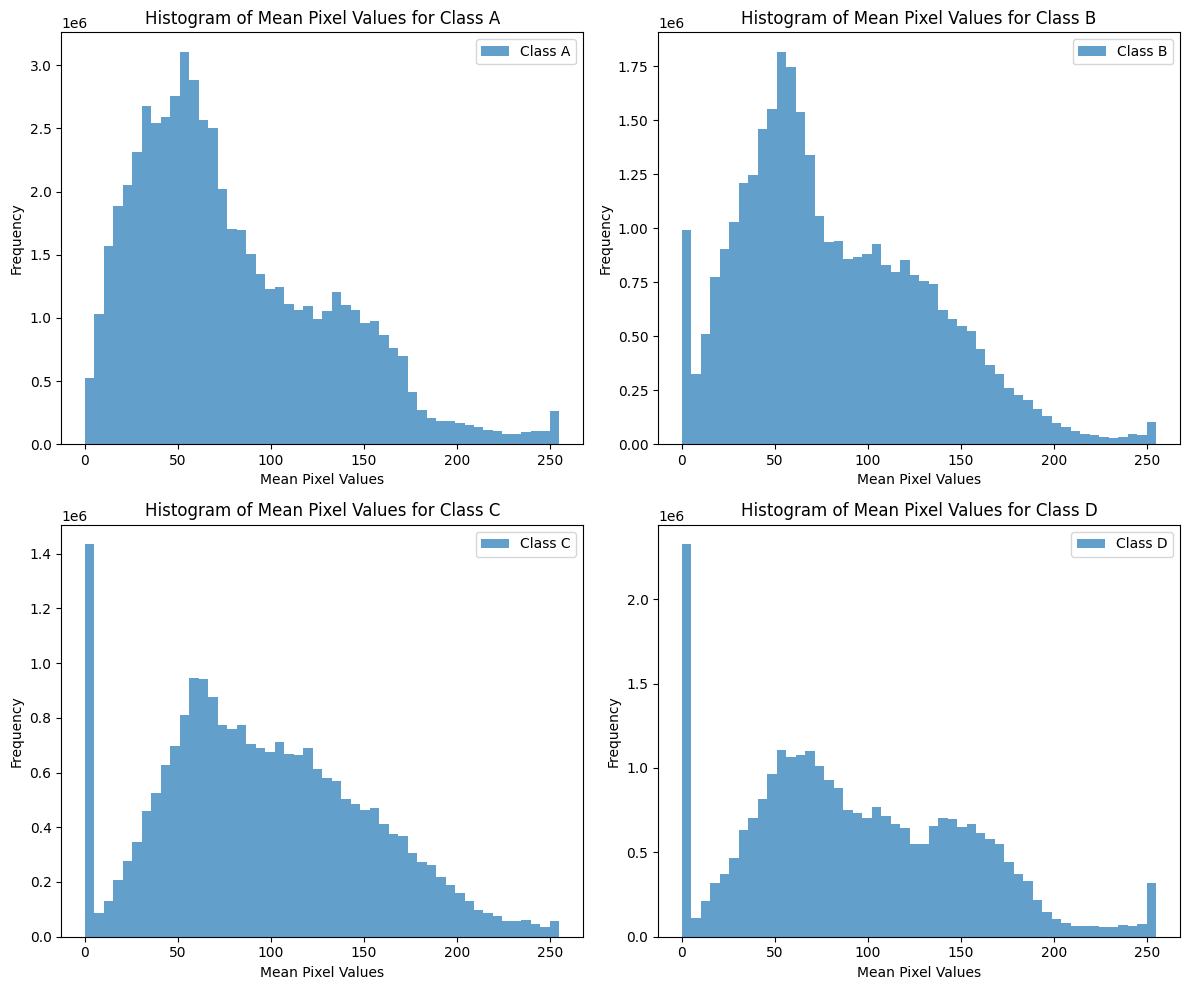

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for idx, class_folder in enumerate(CLASSES):
    class_path = os.path.join(TRAIN_DIR, class_folder)
    mean_pixels = calculate_mean_pixel(class_path)
    plot_histogram(axs[idx // 2, idx % 2], class_folder, mean_pixels)

plt.tight_layout()
plt.show()

In [6]:
def compute_mean_pixel_stats(class_name):
    class_path = os.path.join(TRAIN_DIR, class_name)
    mean_pixels = calculate_mean_pixel(class_path)
    stats = {
        "Class": class_name,
        "Mean": np.mean(mean_pixels),
        "Std Dev": np.std(mean_pixels),
        "Median": np.median(mean_pixels),
        "Min": np.min(mean_pixels),
        "Max": np.max(mean_pixels),
        "25th Percentile": np.percentile(mean_pixels, 25),
        "75th Percentile": np.percentile(mean_pixels, 75),
    }
    return stats

In [7]:
all_stats = []
for class_folder in CLASSES:
    mean_pixel_stats = compute_mean_pixel_stats(class_folder)
    all_stats.append(mean_pixel_stats)

mean_pixel_stats_df = pd.DataFrame(all_stats)

In [8]:
mean_pixel_stats_df

Class       Mean    Std Dev     Median  Min    Max  25th Percentile  \
0  Class A  79.476857  51.412353  66.666667  0.0  255.0        40.333333   
1  Class B  82.264433  50.300347  71.000000  0.0  255.0        45.000000   
2  Class C  95.743317  55.210130  90.666667  0.0  255.0        56.333333   
3  Class D  93.470258  58.363741  85.666667  0.0  255.0        51.000000   

   75th Percentile  
0            113.0  
1            117.0  
2            134.0  
3            138.0

## Histogram of Oriented Gradients (HOG)

In [9]:
pixels_per_cell_list = [(8, 8), (16, 16), (8, 16)]
cells_per_block_list = [(2, 2), (3, 3), (4, 4)]
block_norm_list = ["L1", "L2-Hys"]

hog_parameter_combinations = list(
    itertools.product(pixels_per_cell_list, cells_per_block_list, block_norm_list)
)

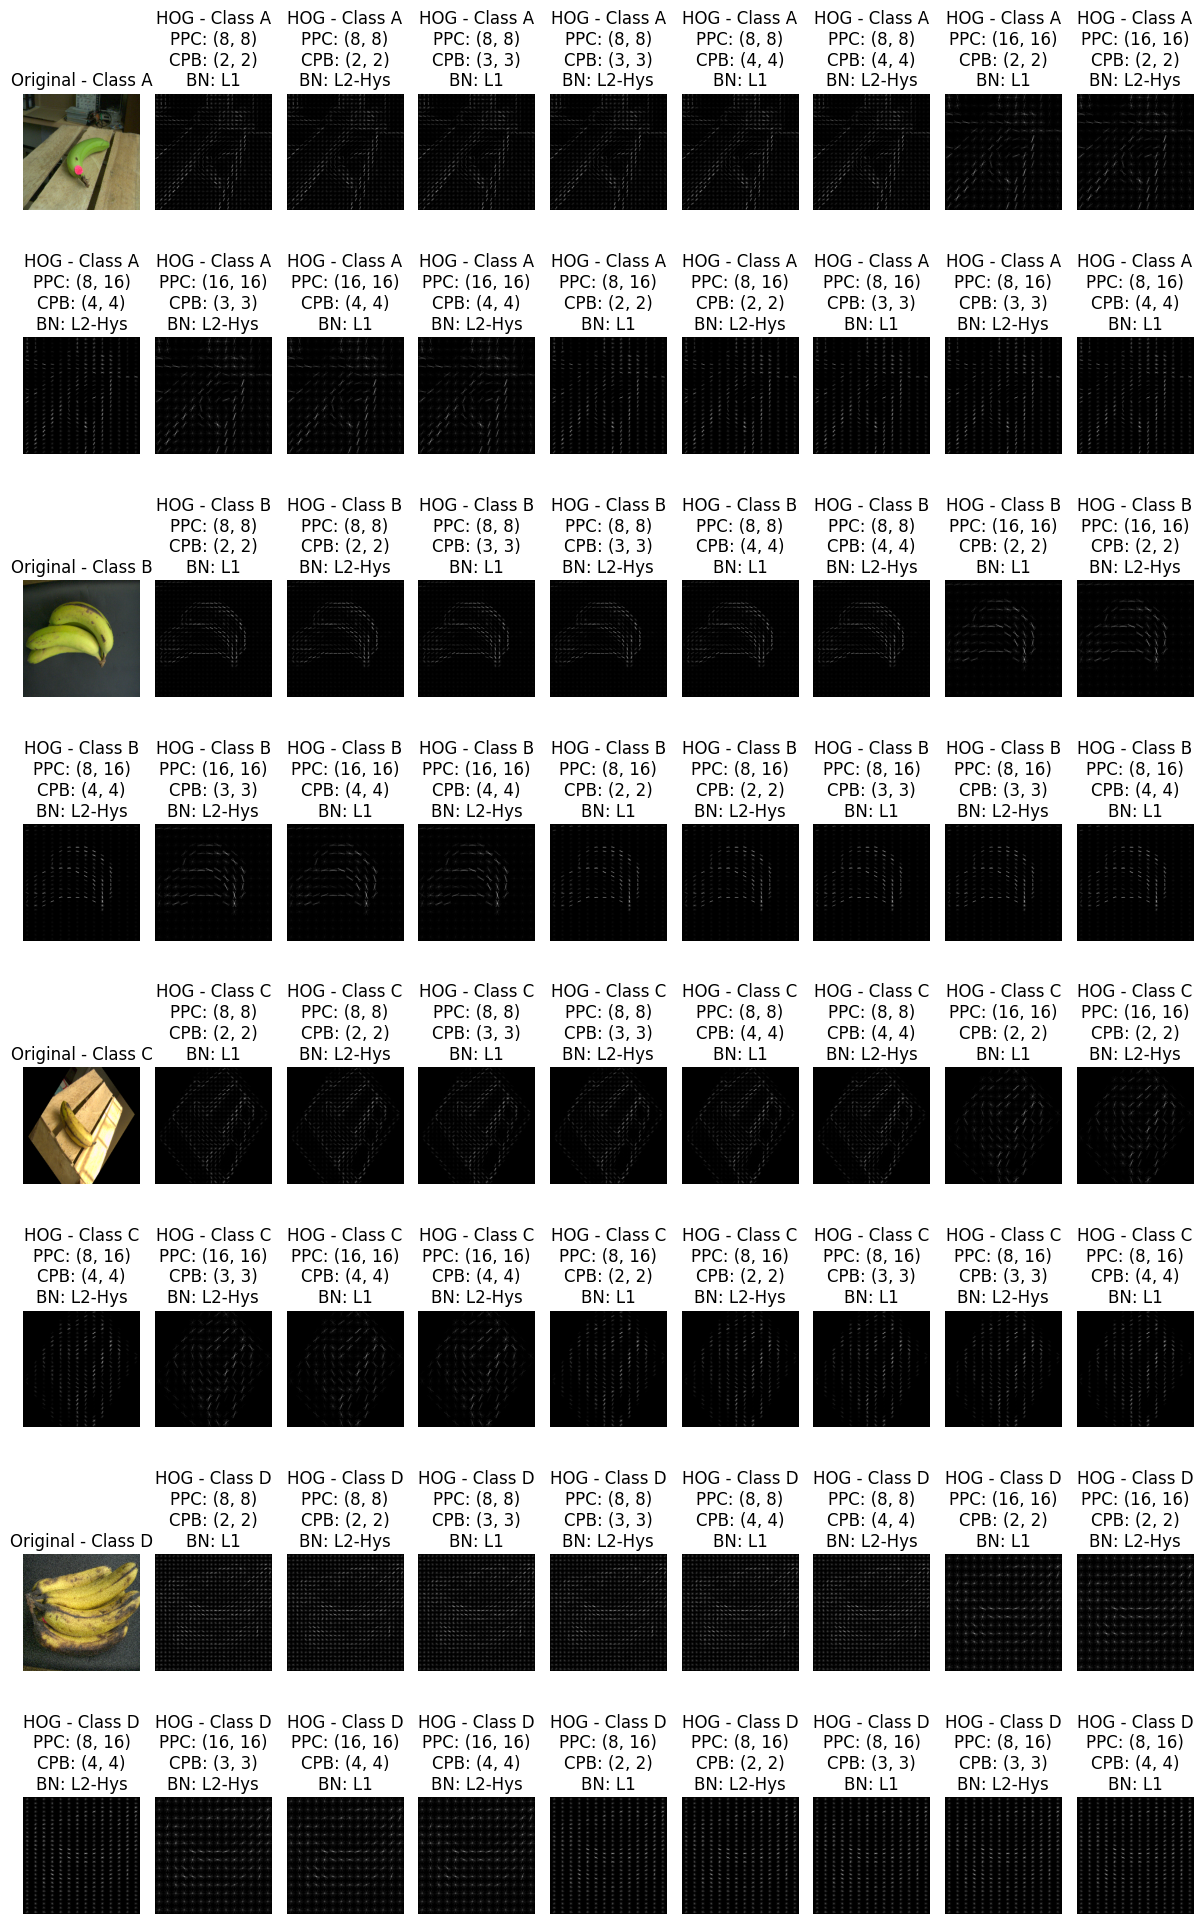

In [10]:
img_per_row = (len(hog_parameter_combinations) + 1) // 2

fig, axs = plt.subplots(len(CLASSES) * 2, img_per_row, figsize=(12, 20))

row_num = -1

for idx, class_name in enumerate(CLASSES, start=0):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_folder)
    random_image = random.choice(images)
    img_path = os.path.join(class_folder, random_image)
    image = io.imread(img_path)
    image_gray = color.rgb2gray(image)
    row_num += 1

    axs[row_num, 0].imshow(image)
    axs[row_num, 0].set_title(f"Original - {class_name}")
    axs[row_num, 0].axis("off")

    for i, params in enumerate(hog_parameter_combinations, start=1):
        pixels_per_cell, cells_per_block, block_norm = params

        # Calculate HOG features with different parameter combinations
        _, hog_image = feature.hog(
            image_gray,
            visualize=True,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm,
        )
        axs[row_num, i % img_per_row].imshow(hog_image, cmap=plt.cm.gray)
        axs[row_num, i % img_per_row].set_title(
            f"HOG - {class_name}\nPPC: {pixels_per_cell}\nCPB: {cells_per_block}\nBN: {block_norm}"
        )
        axs[row_num, i % img_per_row].axis("off")
        if i == img_per_row - 1:
            row_num += 1

plt.tight_layout()
plt.show()

## Local Binary Patterns (LBP)

In [11]:
radius_list = [1, 2, 3]
n_points_list = [8, 12, 16]

lbp_parameter_combinations = list(itertools.product(radius_list, n_points_list))

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


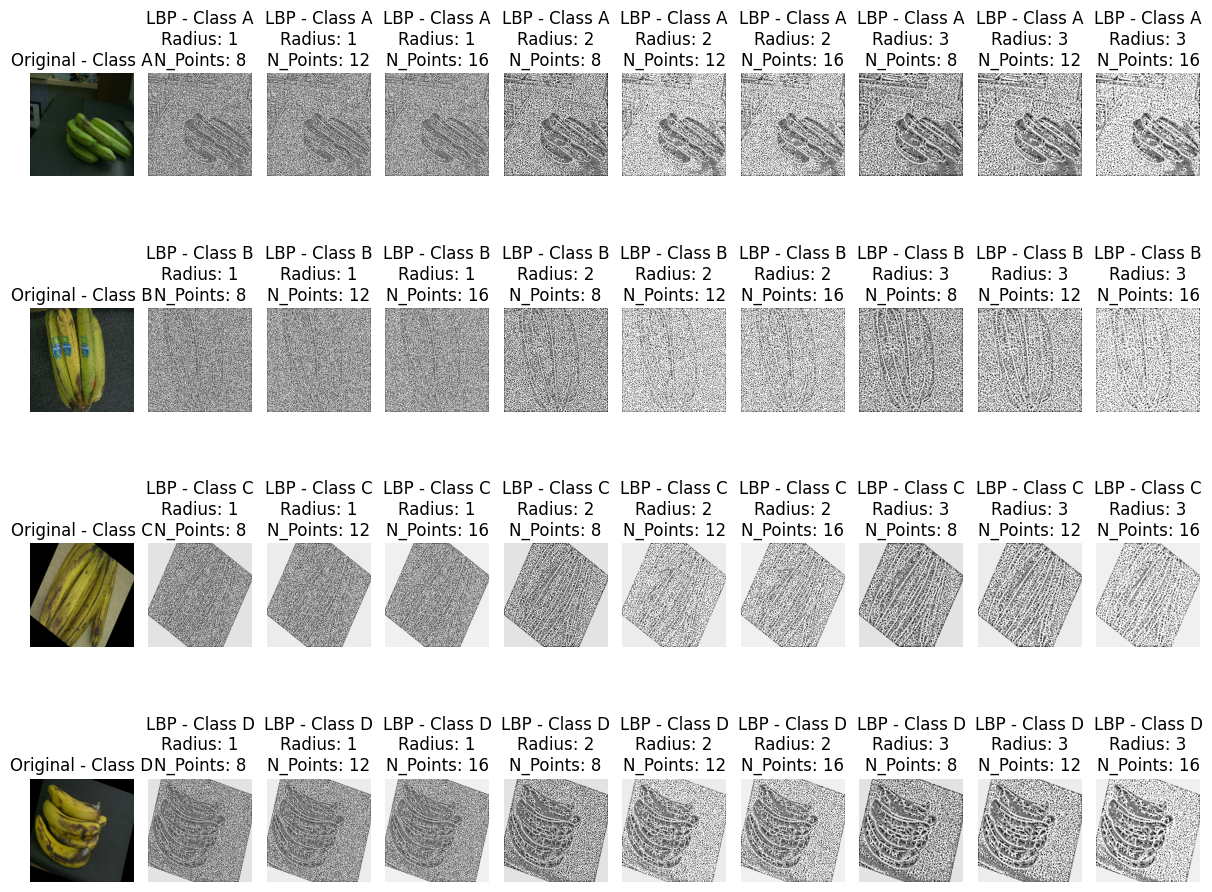

In [12]:
fig, axs = plt.subplots(
    len(CLASSES), len(lbp_parameter_combinations) + 1, figsize=(12, 10)
)

for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_folder)
    random_image = random.choice(images)
    img_path = os.path.join(class_folder, random_image)
    image = io.imread(img_path)
    image_gray = color.rgb2gray(image)

    # Display the original image in the first column
    axs[idx, 0].imshow(image)
    axs[idx, 0].set_title(f"Original - {class_name}")
    axs[idx, 0].axis("off")

    for i, params in enumerate(lbp_parameter_combinations, start=1):
        radius, n_points = params

        lbp = feature.local_binary_pattern(
            image_gray, n_points, radius, method="uniform"
        )

        axs[idx, i].imshow(lbp, cmap="gray")
        axs[idx, i].set_title(
            f"LBP - {class_name}\nRadius: {radius}\nN_Points: {n_points}"
        )
        axs[idx, i].axis("off")

plt.tight_layout()
plt.show()

### Scale-Invariant Feature Transform (SIFT)

In [13]:
sift = cv2.SIFT_create()

In [14]:
fig, axs = plt.subplots(len(CLASSES), 4, figsize=(16, 16))

for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_folder)
    random_image = random.choice(images)
    img_path = os.path.join(class_folder, random_image)
    image = cv2.imread(img_path)

    axs[idx, 0].imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    )
    axs[idx, 0].set_title(f"Original - {class_name}")
    axs[idx, 0].axis("off")

    channels = cv2.split(image)

    for i, channel in enumerate(channels, start=1):
        keypoints, descriptors = sift.detectAndCompute(channel, None)

        image_with_keypoints = cv2.drawKeypoints(channel, keypoints, None)

        axs[idx, i].imshow(image_with_keypoints, cmap="gray")
        axs[idx, i].set_title(f"SIFT - {class_name} - Channel {i-1}")
        axs[idx, i].axis("off")

plt.tight_layout()
plt.show()

## CLAHE

In [ ]:
fig, axs = plt.subplots(len(CLASSES), 5, figsize=(12, 12))

for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_folder)
    random_image = random.choice(images)
    img_path = os.path.join(class_folder, random_image)
    image = cv2.imread(img_path)

    axs[idx, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[idx, 0].set_title(f"Original - {class_name}")
    axs[idx, 0].axis("off")

    # Apply CLAHE for local contrast enhancement to the original image
    clahe_original = exposure.equalize_adapthist(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB), clip_limit=0.03
    )

    axs[idx, 1].imshow(clahe_original, cmap="gray")
    axs[idx, 1].set_title(f"CLAHE Original - {class_name}")
    axs[idx, 1].axis("off")

    # Apply CLAHE for local contrast enhancement to each channel
    channels = cv2.split(image)
    clahe_channels = [
        exposure.equalize_adapthist(ch, clip_limit=0.03) for ch in channels
    ]

    for i, channel in enumerate(clahe_channels, start=2):
        axs[idx, i].imshow(channel, cmap="gray")
        axs[idx, i].set_title(f"CLAHE - {class_name} - Channel {i-1}")
        axs[idx, i].axis("off")

plt.tight_layout()
plt.show()

## Color Thresholding

### Based on heuristics

In [16]:
# Green Bananas (Unripe)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([40, 255, 255])

# Yellow Bananas (Ripe)
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

# Brown Bananas (Overripe)
lower_brown = np.array([10, 60, 60])
upper_brown = np.array([30, 255, 200])

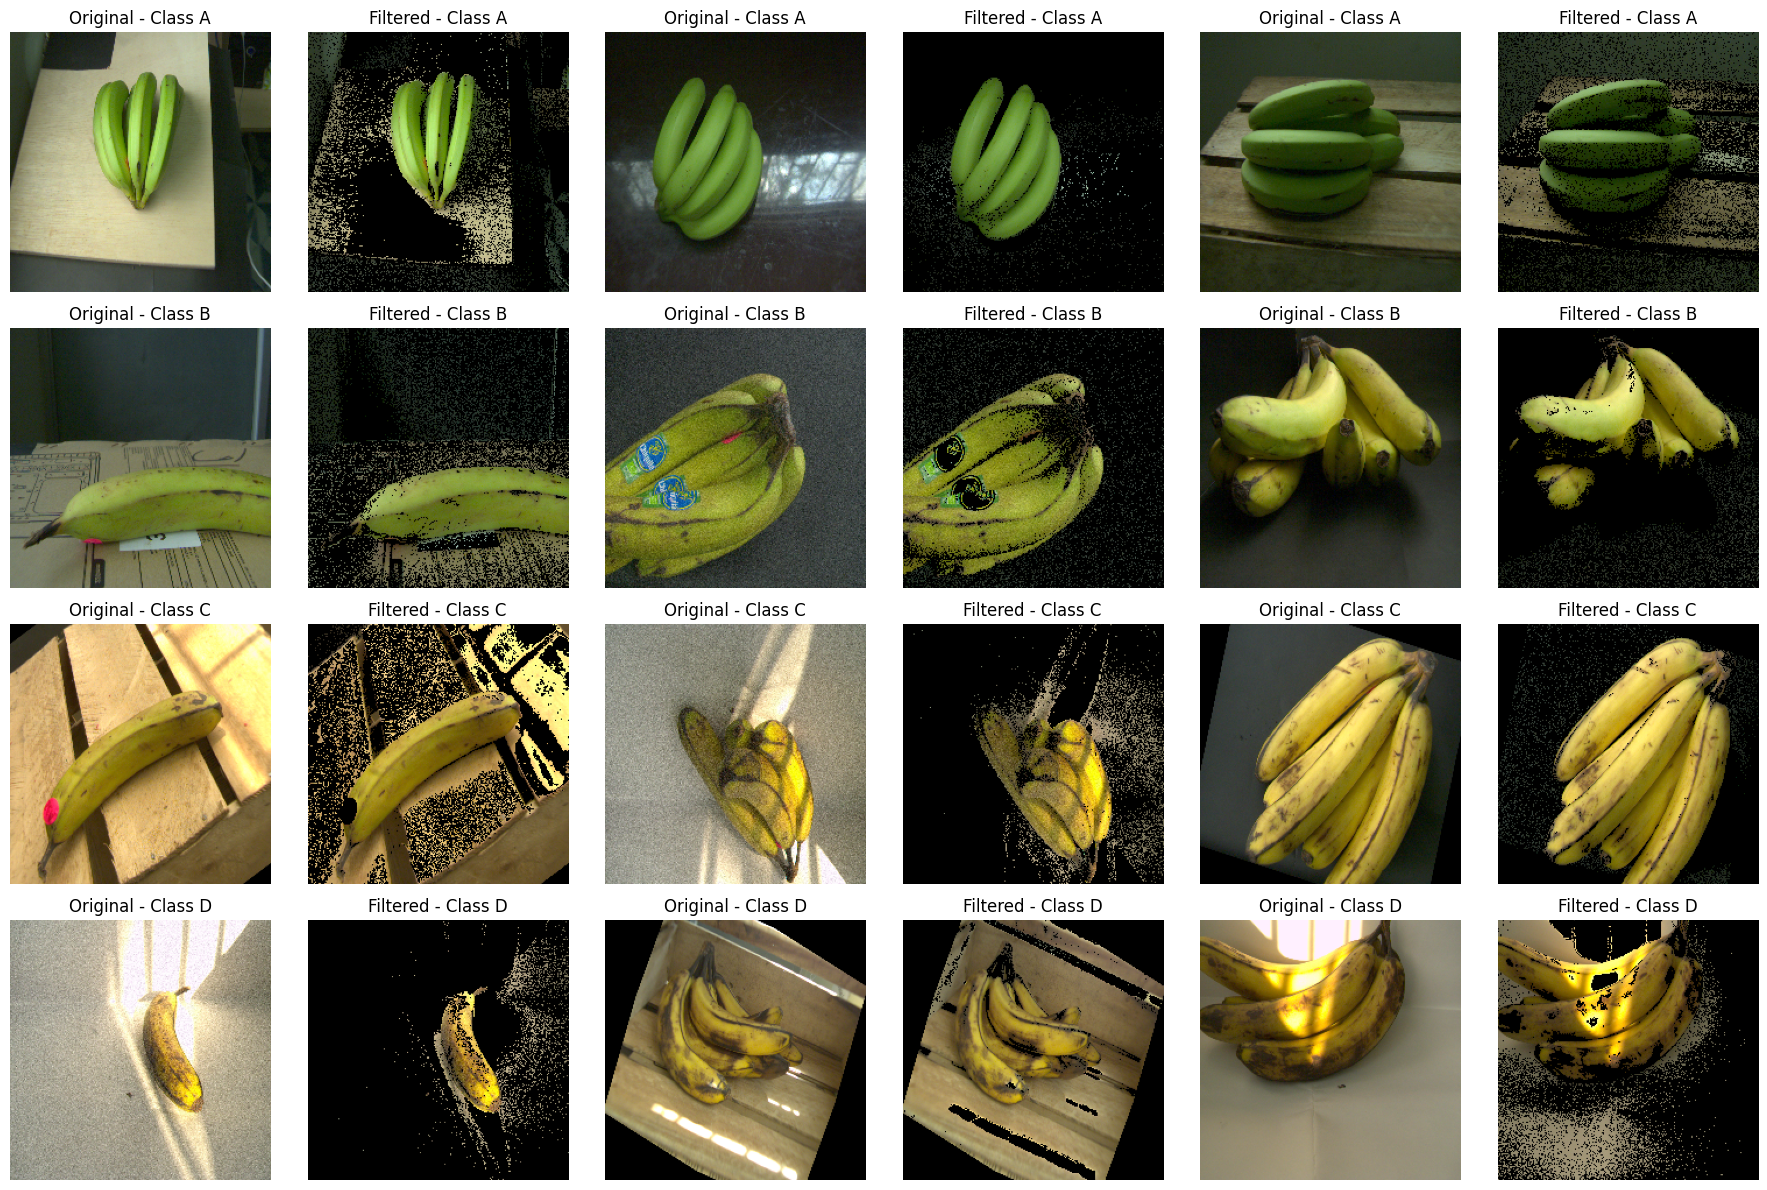

In [17]:
fig, axs = plt.subplots(len(CLASSES), 6, figsize=(18, 12))

for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_folder)

    for i in range(3):
        random_image = random.choice(images)
        img_path = os.path.join(class_folder, random_image)
        image = cv2.imread(img_path)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        col_offset = i * 2

        axs[idx, col_offset].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[idx, col_offset].set_title(f"Original - {class_name}")
        axs[idx, col_offset].axis("off")

        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
        final_mask = cv2.bitwise_or(mask_yellow, mask_green)
        final_mask = cv2.bitwise_or(final_mask, mask_brown)
        result = cv2.bitwise_and(image, image, mask=final_mask)

        axs[idx, col_offset + 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        axs[idx, col_offset + 1].set_title(f"Filtered - {class_name}")
        axs[idx, col_offset + 1].axis("off")

plt.tight_layout()
plt.show()

### Based on percentiles - HSV

In [18]:
def compute_hsv_channel_stats(directory, class_name):
    channel_stats = {
        "Hue": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
        "Saturation": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
        "Value": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
    }

    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    all_hues = []
    all_saturations = []
    all_values = []

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Convert RGB image to HSV
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split channels (Hue, Saturation, Value)
        h, s, v = cv2.split(img_hsv)

        all_hues.extend(h.flatten())
        all_saturations.extend(s.flatten())
        all_values.extend(v.flatten())

    for channel, values in zip(
        ["Hue", "Saturation", "Value"], [all_hues, all_saturations, all_values]
    ):
        for i in range(10, 100, 10):
            channel_stats[channel][f"{i}th_percentile"] = np.percentile(values, i)

    return channel_stats

In [19]:
all_stats = []
for class_name in CLASSES:
    hsv_stats = compute_hsv_channel_stats(TRAIN_DIR, class_name)

    for channel, stats in hsv_stats.items():
        stats_to_store = {
            "Class": class_name,
            "Channel": channel,
            **{
                f"{i}th Percentile": stats[f"{i}th_percentile"]
                for i in range(10, 100, 10)
            },
        }
        all_stats.append(stats_to_store)

hsv_stats_df = pd.DataFrame(all_stats)

In [20]:
def threshold_image(img, lower_thresholds, upper_thresholds):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    mask_hue = cv2.inRange(h, lower_thresholds["Hue"], upper_thresholds["Hue"])
    mask_saturation = cv2.inRange(
        s, lower_thresholds["Saturation"], upper_thresholds["Saturation"]
    )
    mask_value = cv2.inRange(v, lower_thresholds["Value"], upper_thresholds["Value"])

    final_mask = cv2.bitwise_or(mask_hue, mask_saturation)
    final_mask = cv2.bitwise_or(final_mask, mask_value)

    result = cv2.bitwise_and(img, img, mask=final_mask)
    return result

In [21]:
def extract_random_images(directory, class_name, num_images=3):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)
    random_images = random.sample(image_files, num_images)
    images = []
    for img_file in random_images:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        images.append(img)
    return images

In [22]:
num_images_per_class = 3
all_class_images = {}
for class_name in CLASSES:
    images = extract_random_images(TRAIN_DIR, class_name, num_images_per_class)
    all_class_images[class_name] = images

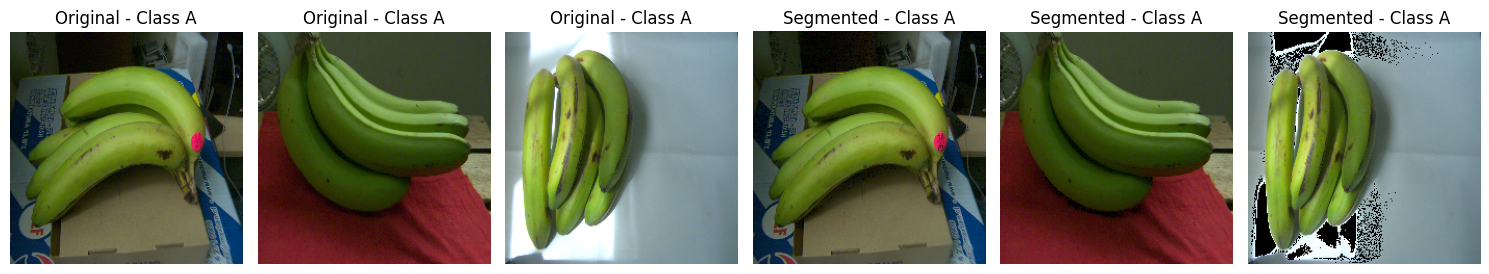

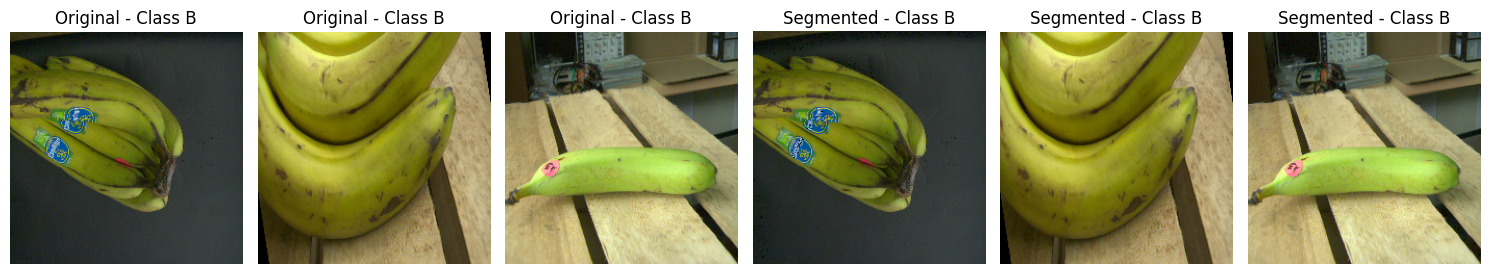

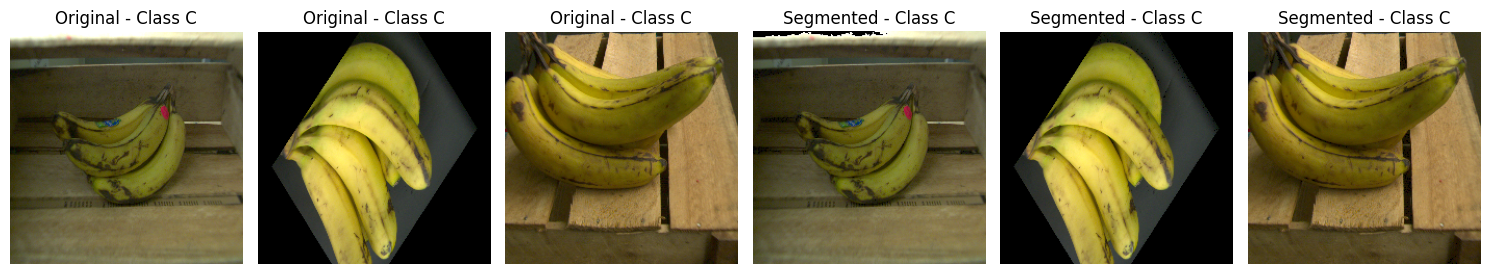

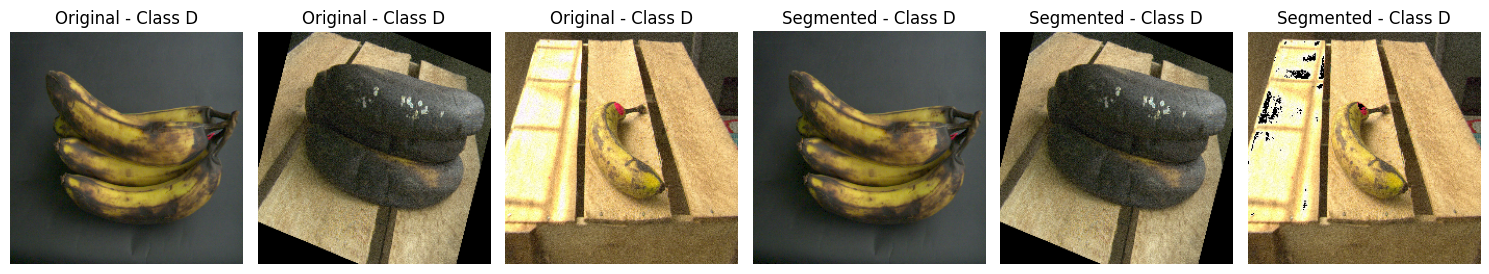

In [23]:
for class_name, images in all_class_images.items():
    fig, axs = plt.subplots(1, 6, figsize=(15, 5))

    for i, img in enumerate(images):
        segmented_img = threshold_image(
            img,
            {
                "Hue": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Hue"),
                    "10th Percentile",
                ].values[0],
                "Saturation": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Saturation"),
                    "10th Percentile",
                ].values[0],
                "Value": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Value"),
                    "10th Percentile",
                ].values[0],
            },
            {
                "Hue": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Hue"),
                    "90th Percentile",
                ].values[0],
                "Saturation": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Saturation"),
                    "90th Percentile",
                ].values[0],
                "Value": hsv_stats_df.loc[
                    (hsv_stats_df["Class"] == class_name)
                    & (hsv_stats_df["Channel"] == "Value"),
                    "90th Percentile",
                ].values[0],
            },
        )
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"Original - {class_name}")
        axs[i].axis("off")

        axs[i + len(images)].imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        axs[i + len(images)].set_title(f"Segmented - {class_name}")
        axs[i + len(images)].axis("off")

    plt.tight_layout()
    plt.show()

### Based on percentiles - LAB

In [24]:
def compute_lab_channel_stats(directory, class_name):
    channel_stats = {
        "L": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
        "A": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
        "B": {f"{i}th_percentile": 0 for i in range(10, 100, 10)},
    }

    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    all_luminance = []
    all_a = []
    all_b = []

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Convert RGB image to LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Split channels (Luminance, A, B)
        l, a, b = cv2.split(img_lab)

        all_luminance.extend(l.flatten())
        all_a.extend(a.flatten())
        all_b.extend(b.flatten())

    for channel, values in zip(["L", "A", "B"], [all_luminance, all_a, all_b]):
        for i in range(10, 100, 10):
            channel_stats[channel][f"{i}th_percentile"] = np.percentile(values, i)

    return channel_stats

In [25]:
all_stats = []
for class_name in CLASSES:
    lab_stats = compute_lab_channel_stats(TRAIN_DIR, class_name)

    for channel, stats in lab_stats.items():
        stats_to_store = {
            "Class": class_name,
            "Channel": channel,
            **{
                f"{i}th Percentile": stats[f"{i}th_percentile"]
                for i in range(10, 100, 10)
            },
        }
        all_stats.append(stats_to_store)

lab_stats_df = pd.DataFrame(all_stats)

In [26]:
lab_stats_df

Class Channel  10th Percentile  20th Percentile  30th Percentile  \
0   Class A       L             27.0             43.0             59.0   
1   Class A       A            104.0            111.0            115.0   
2   Class A       B            124.0            128.0            132.0   
3   Class B       L             27.0             47.0             61.0   
4   Class B       A            112.0            116.0            119.0   
5   Class B       B            128.0            132.0            137.0   
6   Class C       L             31.0             59.0             76.0   
7   Class C       A            119.0            122.0            123.0   
8   Class C       B            128.0            136.0            143.0   
9   Class D       L             17.0             50.0             68.0   
10  Class D       A            122.0            124.0            125.0   
11  Class D       B            128.0            130.0            136.0   

    40th Percentile  50th Percentile  60th Percentile  70th Percentile  \
0              73.0             87.0            104.0            123.0   
1             118.0            120.0            122.0            123.0   
2             136.0            140.0            144.0            148.0   
3              75.0             92.0            113.0            133.0   
4             121.0            123.0            124.0            126.0   
5             143.0            147.0            151.0            158.0   
6              95.0            114.0            133.0            151.0   
7             125.0            126.0            128.0            128.0   
8             149.0            154.0            161.0            168.0   
9              84.0            103.0            125.0            148.0   
10            127.0            128.0            128.0            129.0   
11            141.0            146.0            149.0            153.0   

    80th Percentile  90th Percentile  
0             147.0            171.0  
1             126.0            130.0  
2             155.0            165.0  
3             153.0            179.0  
4             128.0            130.0  
5             167.0            176.0  
6             172.0            199.0  
7             130.0            133.0  
8             174.0            182.0  
9             167.0            189.0  
10            130.0            132.0  
11            156.0            168.0

In [27]:
def threshold_image_lab(img, lower_thresholds, upper_thresholds):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)

    mask_l = cv2.inRange(l, lower_thresholds["L"], upper_thresholds["L"])
    mask_a = cv2.inRange(a, lower_thresholds["A"], upper_thresholds["A"])
    mask_b = cv2.inRange(b, lower_thresholds["B"], upper_thresholds["B"])

    final_mask = cv2.bitwise_or(mask_l, mask_a)
    final_mask = cv2.bitwise_or(final_mask, mask_b)

    result = cv2.bitwise_and(img, img, mask=final_mask)
    return result

In [28]:
num_images_per_class = 3
all_class_images = {}
for class_name in CLASSES:
    images = extract_random_images(TRAIN_DIR, class_name, num_images_per_class)
    all_class_images[class_name] = images

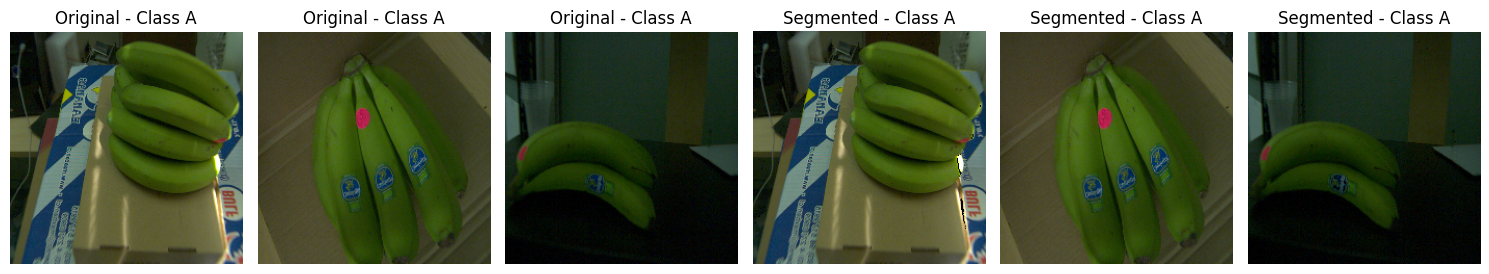

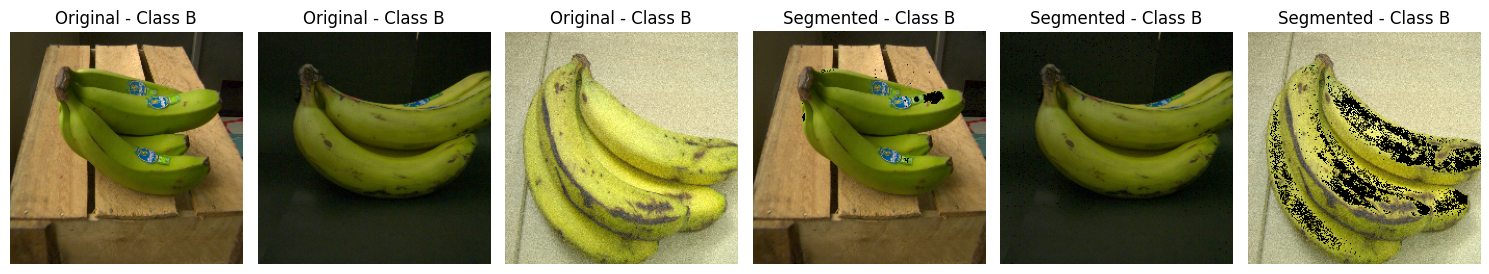

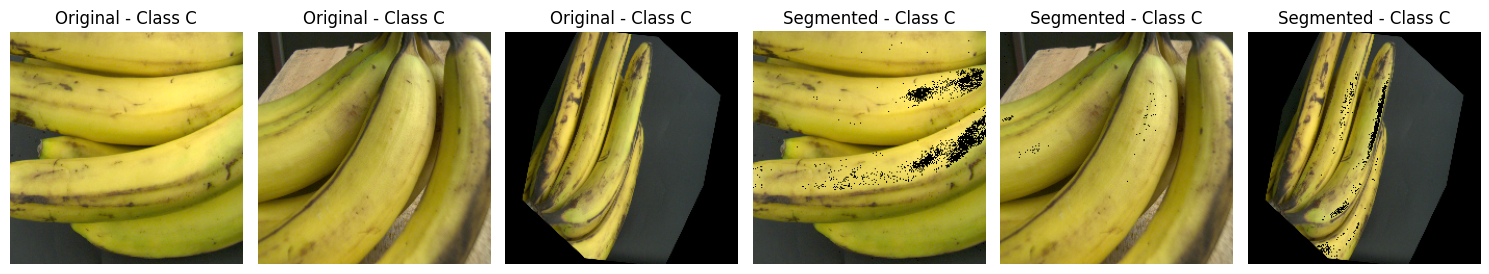

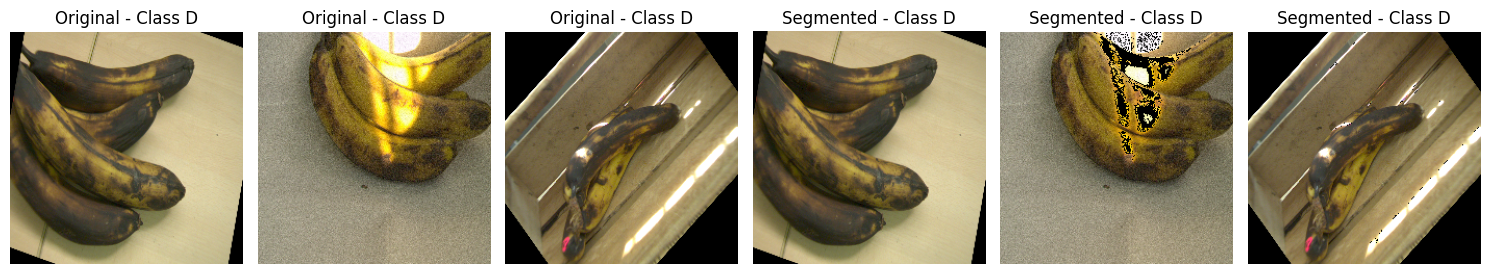

In [29]:
for class_name, images in all_class_images.items():
    fig, axs = plt.subplots(1, 6, figsize=(15, 5))

    for i, img in enumerate(images):
        segmented_img = threshold_image_lab(
            img,
            {
                "L": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "L"),
                    "10th Percentile",
                ].values[0],
                "A": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "A"),
                    "10th Percentile",
                ].values[0],
                "B": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "B"),
                    "10th Percentile",
                ].values[0],
            },
            {
                "L": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "L"),
                    "90th Percentile",
                ].values[0],
                "A": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "A"),
                    "90th Percentile",
                ].values[0],
                "B": lab_stats_df.loc[
                    (lab_stats_df["Class"] == class_name)
                    & (lab_stats_df["Channel"] == "B"),
                    "90th Percentile",
                ].values[0],
            },
        )
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"Original - {class_name}")
        axs[i].axis("off")

        axs[i + len(images)].imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        axs[i + len(images)].set_title(f"Segmented - {class_name}")
        axs[i + len(images)].axis("off")

    plt.tight_layout()
    plt.show()